# Spotify - Classification & Recommendation

## Features reference
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### In order to run this notebook, you will need to get your own Spotify credentials:
Create an application on: https://developer.spotify.com/

#### Author: Bruna Correa

In [1]:
# Load libraries
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors

### Get data from Spotify API using Spotipy

In [2]:
# Instantiate Spotipy
sp = spotipy.Spotify() 

# Credentials and IDs
# Put your own credentials
cid = '#########################' # Client ID
secret = '#########################' # Client Secret
user_id = '#########################' # User ID

# Playlists IDs
# Put your own playlist IDs
like_play_id = '2Ef3fGdmibLpBC5lYqhTia' # Playlist ID: songs that you like
not_like_play_id = '74gPVIUFWIYQYA7d7tUM7p' # Playlist ID: songs that you DON'T like
discover_play_id = '6yeUUCIxul24kft5RbJpRP' # Playlist ID: songs from your "Dicover Weekly" for validation
discover_random_play_id = '6EL2P68pNWfg9cHdreb5gC' # Playlist ID: random new songs for validation 

# Managing credentials and access
client_credentials_manager = SpotifyClientCredentials(client_id=cid, 
                                                      client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

In [3]:
# Function to get song features from a Spotify playlist
def get_playlist_songs(username, playlist_id):
    # Get songs from playlist
    playlist = sp.user_playlist_tracks(username, playlist_id)
    songs = playlist['items']
    while playlist['next']:
        playlist = sp.next(playlist) # use sp.next method to overcome fetch limit of 100 songs
        songs.extend(playlist['items'])
    # Create a list with song ids
    song_ids = [] 
    for i in range(len(songs)): 
        song_ids.append(songs[i]["track"]["id"]) 
    # Create a dataframe with features for each song
    songs_df = pd.DataFrame()
    for song_id in song_ids:
        features = sp.audio_features(song_id) 
        songs_df = songs_df.append(pd.DataFrame(features), ignore_index=True)
    return songs_df

In [4]:
# Get dataFrame with liked songs
like_df = get_playlist_songs(user_id, like_play_id)

# Get dataFrame with not liked songs
not_like_df = get_playlist_songs(user_id, not_like_play_id)

In [5]:
# Add target column (liked songs = 1; not liked = 0)
like_df['like'] = 1
not_like_df['like'] = 0

# Concatenate both dataframes
songs_df = pd.concat([like_df, not_like_df], axis=0).reset_index(drop=True)
print(songs_df.shape)
songs_df.head()

(1250, 19)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,like
0,0.601,0.757,2,-3.341,1,0.0280,0.0139,0.000088,0.0727,0.462,82.001,audio_features,3SWqGa1J0M7hSBUDM0KePD,spotify:track:3SWqGa1J0M7hSBUDM0KePD,https://api.spotify.com/v1/tracks/3SWqGa1J0M7h...,https://api.spotify.com/v1/audio-analysis/3SWq...,189120,4,1
1,0.557,0.747,4,-4.329,0,0.0261,0.0617,0.002480,0.1220,0.672,91.001,audio_features,65wl0TYoyrBFJtotwJiDHl,spotify:track:65wl0TYoyrBFJtotwJiDHl,https://api.spotify.com/v1/tracks/65wl0TYoyrBF...,https://api.spotify.com/v1/audio-analysis/65wl...,233467,4,1
2,0.920,0.914,7,-4.555,1,0.0444,0.0222,0.000076,0.1140,0.974,135.923,audio_features,73mlvsfJM2qwlDUJxeaatI,spotify:track:73mlvsfJM2qwlDUJxeaatI,https://api.spotify.com/v1/tracks/73mlvsfJM2qw...,https://api.spotify.com/v1/audio-analysis/73ml...,314557,4,1
3,0.582,0.962,4,-3.037,1,0.0542,0.0096,0.128000,0.2830,0.506,123.971,audio_features,7aOor99o8NNLZYElOXlBG1,spotify:track:7aOor99o8NNLZYElOXlBG1,https://api.spotify.com/v1/tracks/7aOor99o8NNL...,https://api.spotify.com/v1/audio-analysis/7aOo...,180640,4,1
4,0.713,0.565,7,-7.800,0,0.0351,0.0252,0.000003,0.6330,0.705,130.047,audio_features,3DCU0R5FFaB9GKxZERb5wr,spotify:track:3DCU0R5FFaB9GKxZERb5wr,https://api.spotify.com/v1/tracks/3DCU0R5FFaB9...,https://api.spotify.com/v1/audio-analysis/3DCU...,208981,4,1


In [6]:
# Make sure there are no missing values
songs_df.isnull().sum()
# There are no missing values

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
like                0
dtype: int64

### Exploratory data analysis

In [7]:
# Describe features
songs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,1250.0,0.601390,0.153422,0.137000,0.488000,0.612000,0.716000,0.975
energy,1250.0,0.570028,0.228428,0.010700,0.393000,0.581500,0.751000,0.990
key,1250.0,5.347200,3.573691,0.000000,2.000000,6.000000,9.000000,11.000
loudness,1250.0,-8.316358,3.954397,-32.770000,-10.357500,-7.692000,-5.538250,1.509
mode,1250.0,0.624800,0.484368,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,1250.0,0.066688,0.066730,0.022700,0.032800,0.042300,0.068875,0.868
acousticness,1250.0,0.402143,0.321407,0.000036,0.090625,0.338000,0.707000,0.995
instrumentalness,1250.0,0.099536,0.233635,0.000000,0.000000,0.000149,0.018025,0.967
liveness,1250.0,0.211841,0.207438,0.021700,0.096750,0.119000,0.234750,0.990
valence,1250.0,0.489464,0.252136,0.033600,0.278250,0.474500,0.686750,0.983


In [8]:
# Get an 'average song' that represents what I like
like_avg = songs_df[songs_df['like'] == 1].describe().loc[['mean','std']]

average_song = songs_df[
    (songs_df['danceability'] < like_avg.danceability[0]+like_avg.danceability[1]) & (songs_df['danceability'] > like_avg.danceability[0]-like_avg.danceability[1]) &
    (songs_df['energy'] < like_avg.energy[0]+like_avg.energy[1]) & (songs_df['energy'] > like_avg.energy[0]-like_avg.energy[1]) &
    (songs_df['loudness'] < like_avg.loudness[0]+like_avg.loudness[1]) & (songs_df['loudness'] > like_avg.loudness[0]-like_avg.loudness[1]) &
    (songs_df['speechiness'] < like_avg.speechiness[0]+like_avg.speechiness[1]) & (songs_df['speechiness'] > like_avg.speechiness[0]-like_avg.speechiness[1]) &
    (songs_df['acousticness'] < like_avg.acousticness[0]+like_avg.acousticness[1]) & (songs_df['acousticness'] > like_avg.acousticness[0]-like_avg.acousticness[1]) &
    (songs_df['instrumentalness'] < like_avg.instrumentalness[0]+like_avg.instrumentalness[1]) & (songs_df['instrumentalness'] > like_avg.instrumentalness[0]-like_avg.instrumentalness[1]) &
    (songs_df['liveness'] < like_avg.liveness[0]+like_avg.liveness[1]) & (songs_df['liveness'] > like_avg.liveness[0]-like_avg.liveness[1]) &
    (songs_df['valence'] < like_avg.valence[0]+like_avg.valence[1]) & (songs_df['valence'] > like_avg.valence[0]-like_avg.valence[1]) &
    (songs_df['tempo'] < like_avg.tempo[0]+like_avg.tempo[1]) & (songs_df['tempo'] > like_avg.tempo[0]-like_avg.tempo[1]) &
    (songs_df['mode'] == 1) &
    (songs_df['key'] == 0) &
    (songs_df['time_signature'] == 4)
]

# Pick one average LIKE song
average_song.iloc[-1].to_frame()
# Song: 'Like a Rolling Stone - Bob Dylan'

,964
danceability,0.483
energy,0.721
key,0
loudness,-6.836
mode,1
speechiness,0.032
acousticness,0.729
instrumentalness,0
liveness,0.189
valence,0.562


In [9]:
# Get an 'average song' that represents what I don't like
nlike_avg = songs_df[songs_df['like'] == 0].describe().loc[['mean','std']]

average_song = songs_df[
    (songs_df['danceability'] < nlike_avg.danceability[0]+nlike_avg.danceability[1]) & (songs_df['danceability'] > nlike_avg.danceability[0]-nlike_avg.danceability[1]) &
    (songs_df['energy'] < nlike_avg.energy[0]+nlike_avg.energy[1]) & (songs_df['energy'] > nlike_avg.energy[0]-nlike_avg.energy[1]) &
    (songs_df['loudness'] < nlike_avg.loudness[0]+nlike_avg.loudness[1]) & (songs_df['loudness'] > nlike_avg.loudness[0]-nlike_avg.loudness[1]) &
    (songs_df['speechiness'] < nlike_avg.speechiness[0]+nlike_avg.speechiness[1]) & (songs_df['speechiness'] > nlike_avg.speechiness[0]-nlike_avg.speechiness[1]) &
    (songs_df['acousticness'] < nlike_avg.acousticness[0]+nlike_avg.acousticness[1]) & (songs_df['acousticness'] > nlike_avg.acousticness[0]-nlike_avg.acousticness[1]) &
    (songs_df['instrumentalness'] < nlike_avg.instrumentalness[0]+nlike_avg.instrumentalness[1]) & (songs_df['instrumentalness'] > nlike_avg.instrumentalness[0]-nlike_avg.instrumentalness[1]) &
    (songs_df['liveness'] < nlike_avg.liveness[0]+nlike_avg.liveness[1]) & (songs_df['liveness'] > nlike_avg.liveness[0]-nlike_avg.liveness[1]) &
    (songs_df['valence'] < nlike_avg.valence[0]+nlike_avg.valence[1]) & (songs_df['valence'] > nlike_avg.valence[0]-nlike_avg.valence[1]) &
    (songs_df['tempo'] < nlike_avg.tempo[0]+nlike_avg.tempo[1]) & (songs_df['tempo'] > nlike_avg.tempo[0]-nlike_avg.tempo[1]) &
    (songs_df['mode'] == 1) &
    (songs_df['key'] == 7) &
    (songs_df['time_signature'] == 4)
]

# Pick one average NOT_LIKE song
average_song.iloc[-1].to_frame()
# Song: 'Americana -  DJ Nene'


,1172
danceability,0.691
energy,0.628
key,7
loudness,-6.868
mode,1
speechiness,0.0612
acousticness,0.304
instrumentalness,0
liveness,0.0511
valence,0.938


In [10]:
# List of 13 song features
# All features
song_features = list(songs_df.describe().columns)
# Target feature
song_target = 'like'
# Categorical features
song_features_cat = ['key', 'mode', 'time_signature']
# Continuos features
song_features_cont = [feature for feature in song_features if feature not in song_features_cat+[song_target]]

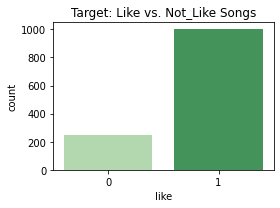

In [11]:
# Plot target variable 'like' counts
plt.figure(figsize=(4,3))
sns.countplot(x=song_target, 
              data=songs_df,
              palette='Greens')
plt.title('Target: Like vs. Not_Like Songs', fontsize=12)
plt.tight_layout()
# target variable is very unbalanced

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


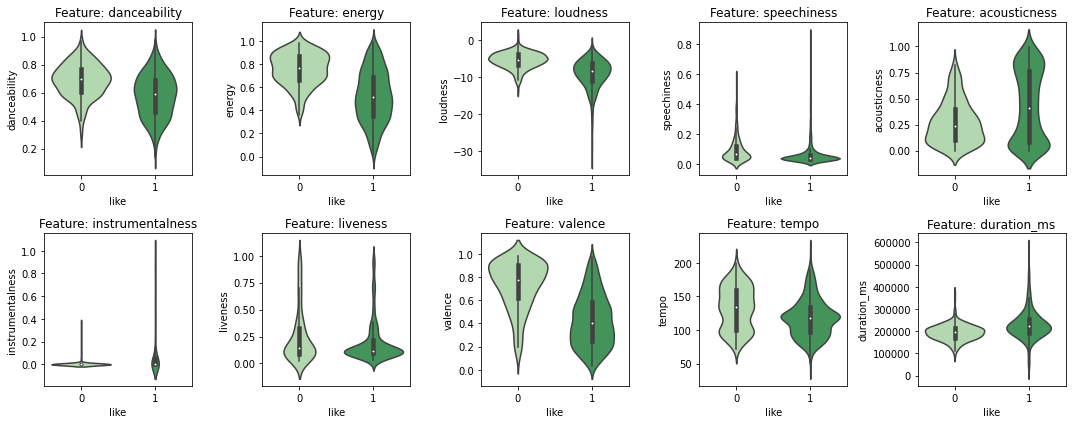

In [14]:
# Plot continuous features
ncol = 5
nrow = len(song_features_cont) / ncol
    
plt.figure(figsize=(15,6))
for i, feat in enumerate(song_features_cont):
    plt.subplot(nrow,ncol,i+1)
    sns.violinplot(y=feat, 
                   x=song_target,
                   data=songs_df,
                   palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout()

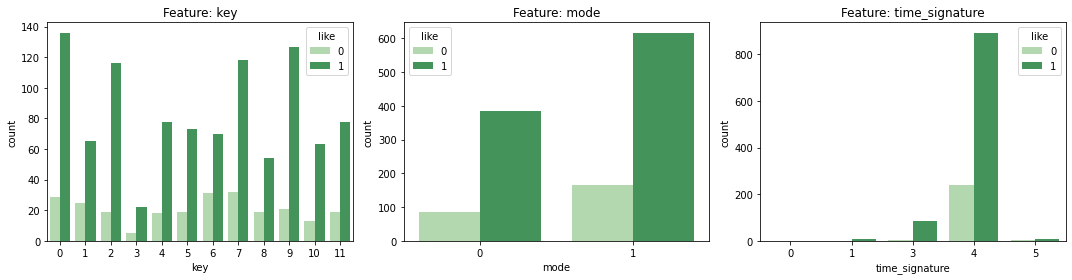

In [15]:
# Plot categorical features
ncol = len(song_features_cat)
nrow = 1

plt.figure(figsize=(15,4))
for i, feat in enumerate(song_features_cat):
    plt.subplot(nrow,ncol,i+1)
    sns.countplot(x=feat, 
                  data=songs_df,
                  hue=song_target,
                  palette='Greens')
    plt.title('Feature: ' + feat, fontsize=12)
plt.tight_layout()

In [16]:
# Define function to perform Mann-Whitney Test and get p-value
# to identify which features have different distributions 
# when comparing like vs. not_like songs

def get_mannwhitney_p(group1, group2, features):
    pval_dict = {}
    for feat in features:
        stat, p = mannwhitneyu(group1[feat], group2[feat])
        pval_dict[feat] = p
    return pval_dict

# Split data by target 'like'
like = songs_df[songs_df[song_target]==1]
not_like = songs_df[songs_df[song_target]==0]

# Run test
mann_whit_results = get_mannwhitney_p(group1=like, 
                                      group2=not_like, 
                                      features=song_features_cont)

# Return features with pvalue < 0.05
p_dict = { key:value for (key,value) in mann_whit_results.items() if value < 0.05 }
sort_p = pd.DataFrame(sorted(p_dict.items(), key=lambda x: x[1], reverse=False))
sort_p.columns = ['feature','pvalue']
print(f'Significant Features:\n\n {sort_p}')
# All 10 continuous features are significant

Significant Features:

             feature        pvalue
0           valence  3.809726e-59
1          loudness  6.398669e-50
2            energy  9.897383e-50
3  instrumentalness  2.107401e-43
4      danceability  8.823610e-25
5       duration_ms  4.523344e-21
6       speechiness  2.388415e-19
7             tempo  4.779544e-11
8      acousticness  5.291756e-08
9          liveness  4.265676e-02


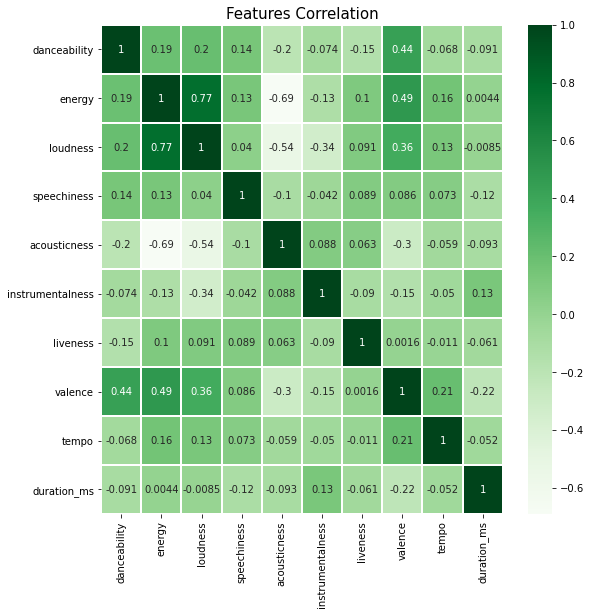

In [18]:
# Correlation plot - Heatmap
corr=songs_df[song_features_cont].corr()
ax = plt.figure(figsize=(9,9))
sns.heatmap(corr,
            annot=True,
            linewidths=1,
            cmap="Greens")
#sns.palplot(sns.color_palette("BuGn_r"))
plt.title("Features Correlation",size=15)
plt.show()

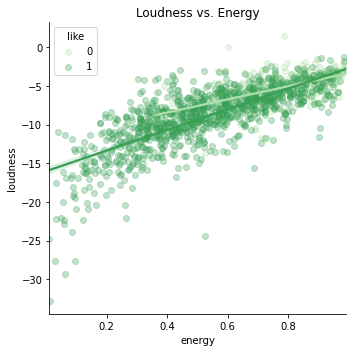

In [19]:
# Some features have moderate to high positive correlation

# Loudness and Energy
sns.lmplot(y='loudness',
           x='energy',
           data=songs_df, 
           hue=song_target,
           scatter_kws={'alpha':0.3},
           palette='Greens',
           legend_out=False)
plt.title('Loudness vs. Energy')
plt.tight_layout()

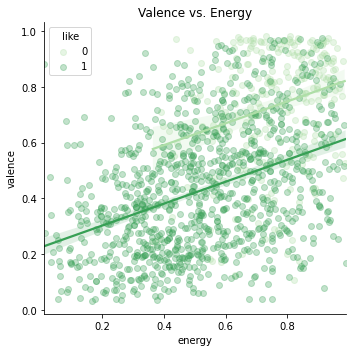

In [20]:
# Valence and Energy
sns.lmplot(y='valence',
           x='energy',
           data=songs_df, 
           hue=song_target,
           scatter_kws={'alpha':0.3},
           palette='Greens',
           legend_out=False)
plt.title('Valence vs. Energy')
plt.tight_layout()

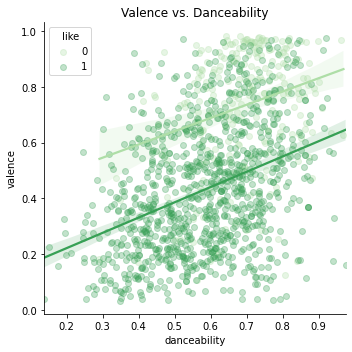

In [21]:
# Valence and Danceability
sns.lmplot(y='valence',
           x='danceability',
           data=songs_df, 
           hue=song_target,
           scatter_kws={'alpha':0.3},
           palette='Greens',
           legend_out=False)
plt.title('Valence vs. Danceability')
plt.tight_layout()

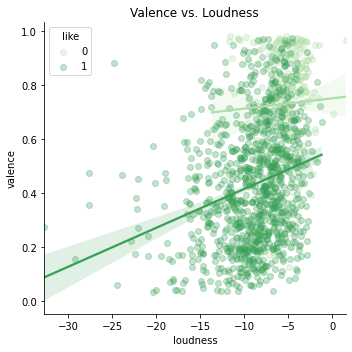

In [22]:
# Valence and Loudness
sns.lmplot(y='valence',
           x='loudness',
           data=songs_df, 
           hue=song_target,
           scatter_kws={'alpha':0.3},
           palette='Greens',
           legend_out=False)
plt.title('Valence vs. Loudness')
plt.tight_layout()

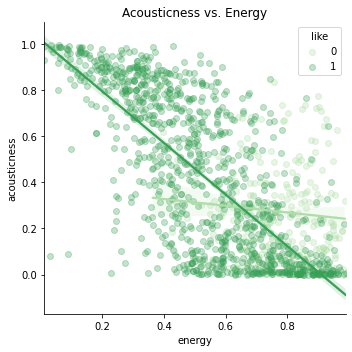

In [23]:
# Acousticness and energy have high negative correlation

# Loudness and Energy
sns.lmplot(y='acousticness',
           x='energy',
           data=songs_df, 
           hue=song_target,
           scatter_kws={'alpha':0.3},
           palette='Greens',
           legend_out=False)
plt.title('Acousticness vs. Energy')
plt.tight_layout()

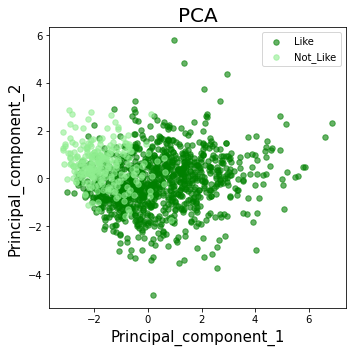

In [25]:
# PCA for dimensionality reduction and visualization

# Feature's scaling
# Initializing scaler
scaler = StandardScaler()
# Separating features from target ('like')
songs_df_std = songs_df[song_features_cont+song_features_cat].values
y = songs_df[song_target].values
# Standardizing features
songs_df_std = StandardScaler().fit_transform(songs_df_std)

# PCA - Data projection in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(songs_df_std)
principal_df = pd.DataFrame(data = principal_components, 
                            columns = ['principal component 1', 'principal component 2'])
# Concatenate std features and target ('like')
songs_df_std_target = pd.concat([principal_df, songs_df[[song_target]]], 
                                axis = 1)

# Plot 2D PCA
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal_component_1', fontsize = 15)
ax.set_ylabel('Principal_component_2', fontsize = 15)
targets = [1, 0]
colors = ['green', 'lightgreen']
for target, color in zip(targets, colors):
    idx = songs_df_std_target['like'] == target
    ax.scatter(songs_df_std_target.loc[idx, 'principal component 1'], 
               songs_df_std_target.loc[idx, 'principal component 2'], 
               c = color,
               s = 30,
               alpha=0.6
              )
ax.legend(['Like','Not_Like'])
plt.title('PCA', fontsize = 20)
plt.tight_layout()

In [26]:
#Explained Variance by the two first principal components
pca.explained_variance_ratio_

array([0.22854586, 0.10019716])

### Classification Models
To predict if a user is going to like a song or not

In [27]:
# Model 1. Baseline Model - Logistic regression - All features

# Get features X and target y
X, y = songs_df[song_features_cont+song_features_cat], songs_df[song_target]

# Define evaluation procedure:
# 3-Fold cross validation - stratified
cross_val = RepeatedStratifiedKFold(n_splits=3, 
                                    n_repeats=5, 
                                    random_state=42
                                   )

# Instantiate model
logistic_model = LogisticRegression()


# Fit and evaluate model with all features
# Performance will be evaluated according F1-Score
logit_scores = cross_val_score(logistic_model, 
                               X, 
                               y, 
                               scoring='f1', 
                               cv=cross_val, 
                               n_jobs=-1
                              )


# Summarize performance - F1-Score
print(f'Mean f1-score: {logit_scores.mean()}')

# Create f1_score dict - To save models' performance
f1_score = {}

# Add to f1_score dict
f1_score['logistic_baseline'] = logit_scores.mean()

Mean f1-score: 0.8801424476636244


In [28]:
# Model 2. Decision Tree - Default parameters

# Instantiate model
tree_model = DecisionTreeClassifier()

# Fit and evaluate model with all features
tree_scores = cross_val_score(tree_model, 
                              X, 
                              y, 
                              scoring='f1', 
                              cv=cross_val, 
                              n_jobs=-1
                             )

# Summarize performance
print(f'Mean f1-score: {tree_scores.mean()}')

# Add to ROC AUC dict
f1_score['decision_tree'] = tree_scores.mean()

Mean f1-score: 0.903924856686133


In [29]:
# Model 3. Random Forest - Default parameters

# Instantiate model
rf_model = RandomForestClassifier()


# Fit and evaluate model with all features
rf_scores = cross_val_score(rf_model, 
                            X,
                            y, 
                            scoring='f1', 
                            cv=cross_val, 
                            n_jobs=-1
                           )


# Summarize performance
print(f'Mean f1-score: {rf_scores.mean()}')

# Add to ROC AUC dict
f1_score['random_forest'] = rf_scores.mean()

Mean f1-score: 0.9434778096251727


In [30]:
# Model 4. ADA Boost - Default parameters

# Instantiate model
ada_model = AdaBoostClassifier() #base_estimator = LogisticRegression()

# Fit and evaluate model with all features
ada_scores = cross_val_score(ada_model,
                             X, 
                             y, 
                             scoring='f1', 
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {ada_scores.mean()}')

# Add to ROC AUC dict
f1_score['ada_boost'] = ada_scores.mean()

Mean f1-score: 0.9335300070882425


In [31]:
# Model 5. XGBoost - Default Parameters

# Instantiate model
xgb_model = XGBClassifier()

# Fit and evaluate model with all features
xgb_scores = cross_val_score(xgb_model, 
                             X, 
                             y, 
                             scoring='f1',
                             cv=cross_val, 
                             n_jobs=-1
                            )

# Summarize performance
print(f'Mean f1-score: {xgb_scores.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost'] = xgb_scores.mean()

Mean f1-score: 0.9428023129632668


In [32]:
# Hyperparameter tunning for XGBoost Model
ratio = (1 - y).sum() / y.sum() # proportion of like / not_like
param_grid = {
    'max_depth': [4,5,6,7],
    'n_estimators': list(range(200, 600)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.1), base = 10, num = 1000)),
    'reg_alpha': list(np.linspace(0.5, 1.5)),
    'reg_lambda': list(np.linspace(0.5, 1.5)),
    'gamma': [0,5,10,15,20],
    'colsample_bytree': list(np.linspace(0.5, 0.9, 10)),
    'colsample_bylevel':list(np.linspace(0.5, 0.9, 10)),
    'min_child_weight': [5,10,20,30,40],
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': np.linspace(ratio-3, ratio+3),
}

# Use randomized search for hyperparameter tuning
rs = RandomizedSearchCV(XGBClassifier(), 
                        param_grid, 
                        scoring='f1', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=1000)
rs.fit(X, y)
best_params = rs.best_params_
rs.best_params_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2110 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.8min finished


{'subsample': 0.8333333333333334,
 'scale_pos_weight': 1.7806122448979593,
 'reg_lambda': 0.5612244897959183,
 'reg_alpha': 0.846938775510204,
 'n_estimators': 487,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.018594802244225328,
 'gamma': 0,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.7222222222222222}

In [40]:
# Model 6. XGBoost with hyperparameter tunning

# Instantiate model
xgb_model_optim = XGBClassifier(subsample = 0.8838383838383839,
                                scale_pos_weight = 1.78061224489795935,
                                reg_lambda = 0.5612244897959183,
                                reg_alpha = 0.846938775510204,
                                n_estimators = 487,
                                min_child_weight = 5,
                                max_depth = 4,
                                learning_rate = 0.018594802244225328,
                                gamma = 0,
                                colsample_bytree = 0.5,
                                colsample_bylevel = 0.7222222222222222)

# Fit and evaluate model with all features
xgb_scores_optim = cross_val_score(xgb_model_optim,
                                   X, 
                                   y, 
                                   scoring='f1',
                                   cv=cross_val, 
                                   n_jobs=-1
                                  )

# Summarize performance
print(f'Mean f1-score: {xgb_scores_optim.mean()}')

# Add to ROC AUC dict
f1_score['xg_boost_optim'] = xgb_scores_optim.mean()

Mean f1-score: 0.9439392817041622


In [41]:
# Metric - f1_score
# Summary for all tested models
f1_score

{'logistic_baseline': 0.8801424476636244,
 'decision_tree': 0.903924856686133,
 'random_forest': 0.9434778096251727,
 'ada_boost': 0.9335300070882425,
 'xg_boost': 0.9428023129632668,
 'xg_boost_optim': 0.9439392817041622}

### Model Validation

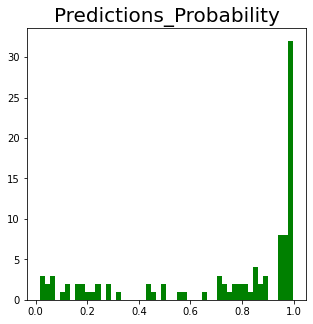

In [43]:
# 'Validation set'
# Use highest scoring model (XGBoost with hyperparameter tunning) 
# to predict like / not_like of a new set of songs
# suggested by Spotify: 'Your Discover Weekly';
# and added also new random songs

# Get validation set: 'Your Discover Weekly'
discover_df = get_playlist_songs(user_id, discover_play_id)
discover_df['discover'] = 1
# Get validation set: Random
discover_random = get_playlist_songs(user_id, discover_random_play_id)
discover_random['discover'] = 0
# Concatenate validation set
discover_complete = pd.concat([discover_df, discover_random], axis=0)

# Validation set
X_val = discover_complete[song_features_cont+song_features_cat]

# Model fit using all train data with all features
xgb_model_optim.fit(X, y)

# Predictions on validation set data:
predictions = xgb_model_optim.predict(X_val)
predictions_prob = xgb_model_optim.predict_proba(X_val)[:,1] #It returns prob of being zero or one, subselect second column (prob of being one)

# Plot - Prediction Probability
plt.figure(figsize=(5,5))
plt.hist(predictions_prob, 
         bins=50,
         color='green'
        )
plt.title('Predictions_Probability', fontsize = 20)
plt.show()

In [44]:
# Add predictions to validation df
discover_df_pred = discover_complete.copy()
discover_df_pred['like_prediction'] = predictions
discover_df_pred['like_probability'] = predictions_prob
discover_df_pred

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,discover,like_prediction,like_probability
0,0.775,0.756,1,-5.471,1,0.1040,0.00207,0.714000,0.2740,0.706,...,audio_features,1g7tqO5lzjQIQxdVZapBwf,spotify:track:1g7tqO5lzjQIQxdVZapBwf,https://api.spotify.com/v1/tracks/1g7tqO5lzjQI...,https://api.spotify.com/v1/audio-analysis/1g7t...,176000,4,1,1,0.961793
1,0.753,0.645,5,-6.738,0,0.0435,0.18600,0.072500,0.1230,0.604,...,audio_features,7fbdTbr12vcmJhWgp58dvO,spotify:track:7fbdTbr12vcmJhWgp58dvO,https://api.spotify.com/v1/tracks/7fbdTbr12vcm...,https://api.spotify.com/v1/audio-analysis/7fbd...,198689,4,1,1,0.975834
2,0.679,0.781,1,-6.141,1,0.0307,0.09520,0.087600,0.1660,0.965,...,audio_features,2k14GJCIjWUuOJ39cloaGk,spotify:track:2k14GJCIjWUuOJ39cloaGk,https://api.spotify.com/v1/tracks/2k14GJCIjWUu...,https://api.spotify.com/v1/audio-analysis/2k14...,286800,4,1,1,0.899679
3,0.830,0.304,5,-11.477,0,0.1740,0.53100,0.000007,0.2490,0.397,...,audio_features,6J0VylxhjHcjJk4lWbjDh4,spotify:track:6J0VylxhjHcjJk4lWbjDh4,https://api.spotify.com/v1/tracks/6J0VylxhjHcj...,https://api.spotify.com/v1/audio-analysis/6J0V...,240289,4,1,1,0.948934
4,0.886,0.408,6,-11.508,0,0.0481,0.22600,0.000536,0.0495,0.814,...,audio_features,0WAZhuiNHBnFVluqlFK5Qb,spotify:track:0WAZhuiNHBnFVluqlFK5Qb,https://api.spotify.com/v1/tracks/0WAZhuiNHBnF...,https://api.spotify.com/v1/audio-analysis/0WAZ...,212040,4,1,1,0.852353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.583,0.937,10,-2.118,1,0.0861,0.44900,0.000000,0.6840,0.938,...,audio_features,71FrGl0XcpL3VId65tB5mg,spotify:track:71FrGl0XcpL3VId65tB5mg,https://api.spotify.com/v1/tracks/71FrGl0XcpL3...,https://api.spotify.com/v1/audio-analysis/71Fr...,166838,4,0,0,0.015775
56,0.794,0.937,8,-2.440,0,0.0336,0.36600,0.000004,0.9620,0.826,...,audio_features,3tv697PZNnaQN0Mn2zGhS5,spotify:track:3tv697PZNnaQN0Mn2zGhS5,https://api.spotify.com/v1/tracks/3tv697PZNnaQ...,https://api.spotify.com/v1/audio-analysis/3tv6...,237517,4,0,0,0.029946
57,0.683,0.883,8,-2.502,1,0.0691,0.37700,0.000000,0.4070,0.678,...,audio_features,3056x1XkmICnQmji68rrft,spotify:track:3056x1XkmICnQmji68rrft,https://api.spotify.com/v1/tracks/3056x1XkmICn...,https://api.spotify.com/v1/audio-analysis/3056...,160565,4,0,0,0.167328
58,0.741,0.848,0,-3.640,1,0.0282,0.05180,0.000000,0.4910,0.885,...,audio_features,08Sd5vVcIH3uKeAiaJdoYj,spotify:track:08Sd5vVcIH3uKeAiaJdoYj,https://api.spotify.com/v1/tracks/08Sd5vVcIH3u...,https://api.spotify.com/v1/audio-analysis/08Sd...,164407,4,0,0,0.185160


In [45]:
# Export predictions
discover_df_pred.to_csv('/data/xgb_model_predictions_validation.csv', index=False)

In [47]:
# Confusion matrix for validation set

# Listen to the validation songs and manually classify them:
# 1: like
# 0: don't like
# Then compare manual classification with predictions

# Import song's manual classification 
y_true = pd.read_csv('/data/songs_manual_classification.csv')

# Model's Predictions
y_pred = discover_df_pred['like_prediction']

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f'True_Pos: {tp}\nFalse_Pos: {fp}\nFalse_Neg: {fn}\nTrue_Neg: {tn}')

True_Pos: 57
False_Pos: 17
False_Neg: 3
True_Neg: 23


In [48]:
# Calculate precision and recall
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: 0.7702702702702703
Recall: 0.95


In [50]:
# Calculate f1_score for validation data
f1_score_val = 2*(precision*recall)/(precision + recall)
print(f'f1_score: {f1_score_val}')

f1_score: 0.8507462686567164


### Recommendation Model
Recommend top 5 songs based on features' similarity.

In [51]:
# K-Nearest Neighbors (KNN) with Manhattan distance

# Merge all datasets
all_songs_df = pd.concat([songs_df[song_features_cont+song_features_cat], 
                          discover_complete[song_features_cont+song_features_cat]],
                         axis=0).reset_index(drop=True)

# Features have different ranges.
# Re-scale them first!
# Initializing scaler
scaler = StandardScaler()

# Separating features from target ('like')
# Standardizing features
all_songs_df_std = pd.DataFrame(StandardScaler().fit_transform(all_songs_df))
all_songs_df_std.columns = all_songs_df.columns
print(all_songs_df_std.shape)
all_songs_df_std.head()
all_songs_df_std.index = pd.concat([songs_df['id'],
                                 discover_complete['id']],
                                 axis=0)

(1350, 13)


In [52]:
# Define function to get artist and song name from song_id
def get_playlist_song_names(df):
    idx_list = []
    for song_id in df.index:
        artist_name = [feat['name'] for feat in sp.track(song_id)['album']['artists']]
        song_name = sp.track(song_id)['name']
        name = ' '.join(map(str, artist_name))  + ':' + song_name       
        idx_list.append(name)
    return idx_list

In [53]:
# Run function to get artists names and song names
artist_songs_list = get_playlist_song_names(all_songs_df_std)

# Add artists names and song names to df index
all_songs_df_std.index = artist_songs_list
all_songs_df_std.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
The Score:Legend,-0.041637,0.807998,1.257626,-0.590971,-1.209081,-0.432149,-0.672381,-0.142791,-1.334674,-0.522895,-0.947798,0.787812,0.215568
Ocean Alley:Infinity,-0.328458,0.763648,1.004307,-0.618659,-1.058371,-0.421983,-0.437005,0.687839,-1.026866,0.155842,-0.386725,-1.269338,0.215568
LCD Soundsystem:Daft Punk Is Playing at My House,2.037813,1.504300,0.946362,-0.351975,-1.182912,-0.432202,-0.475200,1.882366,0.509502,1.396936,0.454885,0.787812,0.215568
Greta Van Fleet:Highway Tune,-0.165492,1.717182,1.335570,-0.209161,-1.222638,0.111603,0.331668,0.031245,0.100734,-0.652682,-0.386725,0.787812,0.215568
Lime Cordiale:Temper Temper,0.688452,-0.043530,0.114359,-0.487503,-1.173453,-0.432512,2.002696,0.818367,0.308538,-0.218919,0.454885,-1.269338,0.215568


In [54]:
# Get song recommendations
# Instantiate knn model
knn = NearestNeighbors(n_neighbors=5,
                       algorithm='auto', 
                       metric='manhattan')

# Recommendation function - Get top 5 recommendations
def get_recommendations(input_df=all_songs_df_std, 
                        song_idx=None):
    
    # Select a wine randomly if none is provided
    if song_idx is None:
        query_index = np.random.choice(input_df.shape[0])
            
    # Use input song name to get index
    else:
        song_name = input_df.index == song_idx
        query_index = [int(idx) for idx in song_name.nonzero()][0]
        
    # Fit knn model
    model_knn = knn.fit(input_df.iloc[:,:])
    
    # Get distances and indexes from the top 5 neighbors
    distance, index_neigh = model_knn.kneighbors(input_df.iloc[query_index,].values.reshape(1,-1), 
                                                 n_neighbors=6)
    
    # Return top 5 recommendations
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print(f'Top 5 recommendations for: \n\n###{input_df.index[query_index]}###\n')
        else:
            print(f'#{i}: {input_df.index[index_neigh.flatten()[i]]}\n')

In [55]:
# Run function

# Get recommendations for 'The Lumineers: Sleep On The Floor'
get_recommendations(song_idx='The Lumineers:Sleep On The Floor')

Top 5 recommendations for: 

###The Lumineers:Sleep On The Floor###

#1: Alex & Sierra:You Will Find Me

#2: Ainda:Millones

#3: Vanguart:Pra Onde Eu Devo Ir?

#4: RÜFÜS DU SOL:Daylight

#5: John Mayer:Never on the Day You Leave



In [64]:
# Get recommendations for a random song
get_recommendations()

Top 5 recommendations for: 

###RÜFÜS DU SOL:No Place###

#1: RÜFÜS DU SOL:Eyes

#2: Duke Dumont Zak Abel:The Power

#3: Bea Miller:burning bridges

#4: Great Gable:Drift

#5: Pol 3.14 Cepeda:Bipolar

